## Imports

In [627]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import norm, expon
from scipy.stats import multivariate_normal
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import GradientBoostingClassifier as GBC
from mpl_toolkits.mplot3d import Axes3D

## PDF Generation

### Gaussian

\begin{equation}
f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}
\end{equation}

### Exponential
 
\begin{equation}
  f(x ;\lambda) =
    \begin{cases}
      \lambda e^{-\lambda x} & x\ge 0\\
      0 & x < 0
    \end{cases}       
\end{equation}

In this notebook, we generate points that belong to two classes with two distribution function. Then we build the Optimal Bayes Classifier (OBC), which is the "best" classifier (in the sense of Bayes probability) to classify points randomly generated in the same way. We eventualy compute some statistics about this OBC like ROC curve, AUC, score distribution.

All the parameters are defined and described in the section "Settings".

### Function that generates the events

In [628]:
def generate_points_gaussian_gaussian (params) :
    try :
        s_nb_events, s_mu, s_s, b_nb_events, b_mu, b_s, nb_bins = params
    except :
        print("Too much or too less parameters")
    DS = np.random.normal(s_mu,s_s,s_nb_events)
    DB = np.random.normal(b_mu,b_s,b_nb_events)
    return DS, DB

In [629]:
def generate_points_gaussian_exp (params) :
    try :
        s_nb_events, s_mu, s_s, b_nb_events, b_loc, b_lam, nb_bins = params
    except :
        print("Too much or too less parameters")
    DS = np.random.normal(s_mu,s_s,s_nb_events)
    DB = np.random.exponential(b_lam,b_nb_events)
    return DS, DB

### Function that estimates parameters with MLE

Maximum likelihood estimates expression of the parameters

$
\mu = \frac{1}{N} \sum_{n=1}^{N} x_n
$
(center of a Gaussian distribution)

$
\sigma^2 = \frac{1}{N} \sum_{n=1}^{N} (x_n - \mu)^2 
$
(squared standard deviation of a Gaussian distribution)

$
\lambda = \frac{N}{\sum_{n=1}^{N} x_n}
$
(inversed scale factor of an exponential distribution)

In [630]:
def MLE_gaussian_gaussian(DS,DB): 
    s_n, b_n = np.shape(DS)[0], np.shape(DB)[0]
    s_mu, b_mu = np.sum(DS)/s_n, np.sum(DB)/b_n
    s_sigma, b_sigma = (np.sum((DS-s_mu)**2)/s_n)**0.5, (np.sum((DB-b_mu)**2)/b_n)**0.5
    return s_mu,s_sigma,b_mu,b_sigma

In [631]:
def MLE_gaussian_exp(DS,DB): 
    s_n, b_n = np.shape(DS)[0], np.shape(DB)[0]
    s_mu, b_lambda = np.sum(DS)/s_n, b_n/np.sum(DB)
    s_sigma = (np.sum((DS-s_mu)**2)/s_n)**0.5
    b_loc = 0
    return s_mu, s_sigma, b_loc, b_lambda

### Function that build the OBC

In [632]:
def build_OBC_gaussian_gaussian (m,M,bins,s_mu,s_sigma,b_mu,b_sigma) :
    x = np.linspace(m,M,bins)
    # are under the curve of background distribution
    Sb = norm.cdf(M,b_mu,b_sigma)-norm.cdf(m,b_mu,b_sigma)
    # are under the curve of signal distribution
    Ss = norm.cdf(M,s_mu,s_sigma)-norm.cdf(m,s_mu,s_sigma)
    # calculate Prior
    priorb = Sb/(Sb+Ss)
    priors = 1-priorb
    # morally calculate Bayes probability that x is signal and background. "Morally" because we don't divise by p(X=x)
    pb = priorb*norm.pdf(x,b_mu,b_sigma)
    ps = priors*norm.pdf(x,s_mu,s_sigma)
    # 0 : background
    # 1 : signal
    prediction = np.zeros(np.shape(x)[0]) + 0
    mask = ps > pb
    prediction[mask] = 1
    #Building OBC
    sto = prediction[0]
    OBC = {m : sto}
    k = 1
    for p in prediction :
        if p != sto :
            sto = abs(sto-1)
            OBC[m+k*(M-m)/bins] = sto
        k += 1   
    return OBC

In [633]:
def build_OBC_gaussian_exp (m,M,bins,mu,sigma,loc,lam) :
    x = np.linspace(m,M,bins)
    # are under the curve of background distribution
    Sb = expon.cdf(M,lam)-expon.cdf(m,lam)
    # are under the curve of signal distribution
    Ss = norm.cdf(M,mu,sigma)-norm.cdf(m,mu,sigma)
    # calculate Prior
    priorb = Sb/(Sb+Ss)
    priors = 1-priorb
    # morally calculate Bayes probability that x is signal and background. "Morally" because we don't divise by p(X=x)
    pb = priorb*expon.pdf(x,0,lam)
    ps = priors*norm.pdf(x,mu,sigma)
    # 0 : background
    # 1 : signal
    prediction = np.zeros(np.shape(x)[0]) + 0
    mask = ps > pb
    prediction[mask] = 1
    #Building OBC
    sto = prediction[0]
    OBC = {m : sto}
    k = 1
    for p in prediction :
        if p != sto :
            sto = abs(sto-1)
            OBC[m+k*(M-m)/bins] = sto
        k += 1   
    return OBC

### Function that predict classes

In [634]:
def predict (OBC,X) :
    n = np.shape(X)[0]
    y_predicted = np.zeros(n)
    for i in range(n) :
        x = X[i]
        for k,v in OBC.items() :
            if x < k :
                y_predicted[i] = abs(v-1)
                break
    return y_predicted

### Function that shade the "most likelihood" regions defined by the OBC 

In [635]:
def shade_OBC_regions(OBC,m,M) :
    colors = {1:"red",0:"blue"}
    sto = m
    for k,v in OBC.items() :
        if k != m :
            plt.axvspan(sto, k, color=colors[OBC[sto]], alpha=0.2)
            sto = k
    plt.axvspan(sto, M, color=colors[OBC[sto]], alpha=0.2)
    plt.legend(['Background', 'Signal'])

### Settings

In this section, we define all the variable. The desired values are stored in the dictionary "Params". They are named in "snake_case" style : "a_b_c" or "a_d"
- a refers to whether the variable is relative to train ("train") or test ("test") points
- b refers to whether the variable is relative to signal ("s") or background ("b") points
- c refers to how the variable is used : 
    - "nb_events" for the number of events,
    - "mu" for the $\mu$ parameter of Gaussian distribution
    - "s" for the $\sigma$ parameter of a Gaussian distribution
    - "loc" for the location of an exponential distribution (the point where its PDF is maximal). We give it as a parameter for future use, but it needs to be set to 0 for now, otherwise the MLE of $\lambda$ is wrong
    - "lam" for the $\lambda$ parameter of an exponential distribution
- d refers to how the variable is used :
    - "params" for tuple of all needed parameters used to generate the points
    - "generation" for the way we generate the points. These different ways are stored in the dictionary "generations"
    
The dicitionary "generations" contains the available ways to generate points

In [636]:
Params = {"train_generation" : "generate_points_gaussian_exp",
          "train_s_nb_events" : 10000,
          "train_s_mu" : 4,
          "train_s_s" : 0.8,
          "train_b_nb_events" : 10000,
          "train_b_loc" : 0,
          "train_b_lam" : 1,
          "train_b_mu" : 0,
          "train_b_s" : 2,
          "train_nb_bins" : 100,

          "test_generation" : "generate_points_gaussian_exp",
          "test_s_nb_events" : 20000,
          "test_s_mu" : 6,
          "test_s_s" : 0.8,
          "test_b_nb_events" : 20000,
          "test_b_loc" : 0,
          "test_b_lam" : 1,
          "test_b_mu" : 0,
          "test_b_s" : 2,
          "test_nb_bins" : 100
}



generations = {"generate_points_gaussian_gaussian" : generate_points_gaussian_gaussian,
              "generate_points_gaussian_exp" : generate_points_gaussian_exp}

train_generation = Params["train_generation"]
train_s_nb_events = Params["train_s_nb_events"]
train_s_mu = Params["train_s_mu"]
train_s_s = Params["train_s_s"]
train_b_nb_events = Params["train_b_nb_events"]
train_b_loc = Params["train_b_loc"]
train_b_lam = Params["train_b_lam"]
train_b_mu = Params["train_b_mu"]
train_b_s = Params["train_b_s"]
train_nb_bins = Params["train_nb_bins"]

if Params["train_generation"] == "generate_points_gaussian_gaussian" :
    train_params = train_s_nb_events, train_s_mu, train_s_s, train_b_nb_events, train_b_mu, train_b_s, train_nb_bins
else :
    train_params = train_s_nb_events, train_s_mu, train_s_s, train_b_nb_events, train_b_loc, train_b_lam, train_nb_bins

test_generation = Params["test_generation"]
test_s_nb_events = Params["test_s_nb_events"]
test_s_mu = Params["test_s_mu"]
test_s_s = Params["test_s_s"]
test_b_nb_events = Params["test_b_nb_events"]
test_b_loc = Params["test_b_loc"]
test_b_lam = Params["test_b_lam"]
test_b_mu = Params["test_b_mu"]
test_b_s = Params["test_b_s"]
test_nb_bins = Params["test_nb_bins"]

if Params["test_generation"] == "generate_points_gaussian_gaussian" :
    test_params = test_s_nb_events, test_s_mu, test_s_s, test_b_nb_events, test_b_mu, test_b_s, test_nb_bins
else :
    test_params = test_s_nb_events, test_s_mu, test_s_s, test_b_nb_events, test_b_loc, test_b_lam, test_nb_bins


### Generating training data

Here we use parameters from the json file as input to create signal dataset (DS) and background dataset (DB)

In [637]:
DS,DB = generations[train_generation](train_params)

### Estimating parameters with MLE

Here, knowing the kind of random distribution used to generate the points but not the parameters, we estimate the parameters with MLE.
To make the distinction between absolute parameters and estimated ones, the name of estimated parameters begins with "e_"

In [638]:
if train_generation == "generate_points_gaussian_gaussian" :
    e_s_mu,e_s_sigma,e_b_mu,e_b_sigma = MLE_gaussian_gaussian(DS,DB)
else :
    e_s_mu,e_s_sigma,e_b_loc,e_b_lam = MLE_gaussian_exp(DS,DB)

### Calculating OBC for estimated parameters

With the estimated parameters, we use the Bayes formula to compute the associated OBC and return the model

In [639]:
m = 0
M = max(np.max(DS),np.max(DB))
if train_generation == "generate_points_gaussian_gaussian" :
    OBC = build_OBC_gaussian_gaussian(m,M,train_nb_bins,e_s_mu,e_s_sigma,e_b_mu,e_b_sigma)
else :
    OBC = build_OBC_gaussian_exp(m,M,train_nb_bins,e_s_mu,e_s_sigma,e_b_loc,e_b_lam)

In [640]:
OBC

{0: 0.0, 2.6046410038869845: 1.0, 6.837182635203335: 0.0}

### Predicting training dataset classes with OBC

In [641]:
y_predicted = np.hstack((predict(OBC,DS),predict(OBC,DB)))

### Showing plot of training data and OBC

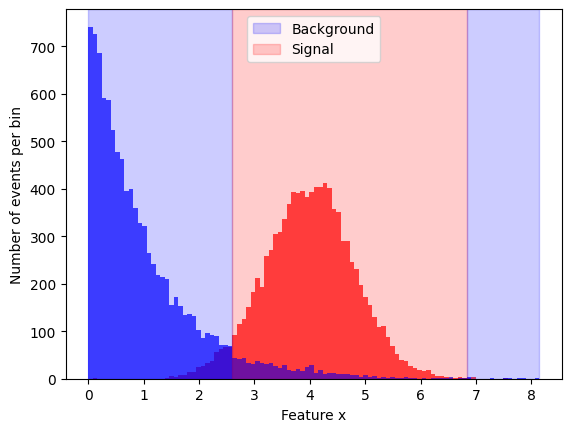

In [642]:
plt.hist(DS,train_nb_bins,range=[m, M], alpha = 0.7, color="red")
plt.hist(DB,train_nb_bins,range=[m, M], alpha = 0.7, color="blue")
plt.xlabel("Feature x")
plt.ylabel("Number of events per bin")

shade_OBC_regions(OBC,m,M)

## Generating Testing Data

For the moment, we simply test the OBC with test points generated in same way (same distributions with absolute parameters) as the training ones.

In [643]:
def generate_test_gaussian_gaussian (params) :
    try :
        s_nb_events, s_mu, s_s, b_nb_events, b_mu, b_s, nb_bins = params
    except :
        print("Param shape doesn't fit")
    DS = np.random.normal(s_mu,s_s,s_nb_events)
    DB = np.random.normal(b_mu,b_s,b_nb_events)
    x = np.hstack((DS,DB))
    y = np.hstack((np.ones(np.shape(DS)),np.zeros(np.shape(DB))))
    return x,y

In [644]:
def generate_test_gaussian_exp (params) :
    try :
        s_nb_events, s_mu, s_s, b_nb_events, b_loc, b_lam, nb_bins = params
    except :
        print("Param shape doesn't fit")
    DS = np.random.normal(s_mu,s_s,s_nb_events)
    DB = np.random.exponential(b_lam,b_nb_events)
    x = np.hstack((DS,DB))
    y = np.hstack((np.ones(np.shape(DS)),np.zeros(np.shape(DB))))
    return x,y

In [645]:
if train_generation == "generate_points_gaussian_gaussian" :
    x_test,y_test = generate_test_gaussian_gaussian(test_params)
else :
    x_test,y_test = generate_test_gaussian_exp(test_params)

### Building ps and pb

Being given a point with feature $x$, we can calculate the probability $p_s$ that it is signal and the probability $p_b$ that it is background using Bayes formula :
\begin{align}
    p_s := p(y=1|X=x) = \frac{p(y=1)p(X=x|y=1)}{p(X=x)}\\
    p_b := p(y=0|X=x) = \frac{p(y=0)p(X=x|y=0)}{p(X=x)}
\end{align}

"ps" and "pb" are the numpy arrays that contains $p_s$(x) and $p_b$(x) for each point x in a given numpy array of points

In [646]:
def build_ps_pb_gaussian_gaussian (params) :
    x,m,M,s_mu,s_sigma,b_mu,b_sigma = params
    Sb = norm.cdf(M,b_mu,b_sigma)-norm.cdf(m,b_mu,b_sigma)
    Ss = norm.cdf(M,s_mu,s_sigma)-norm.cdf(m,s_mu,s_sigma)
    priorb = Sb/(Sb+Ss)
    priors = 1-priorb
    pb = priors*norm.pdf(x,b_mu,b_sigma)
    ps = priors*norm.pdf(x,s_mu,s_sigma)
    ps,pb = normalize(ps,pb) #Using this normalization function is equivalent to divide by p(X=x)
    #ps,pb = remove_zeros_from_pb(ps,pb)
    return ps, pb

In [647]:
def build_ps_pb_gaussian_exp (params) :
    x,m,M,mu,sigma,loc,lam = params
    Sb = expon.cdf(M,lam)-expon.cdf(m,lam)
    Ss = norm.cdf(M,mu,sigma)-norm.cdf(m,mu,sigma)
    priorb = Sb/(Sb+Ss)
    priors = 1-priorb
    pb = priorb*expon.pdf(x,loc,lam)
    ps = priors*norm.pdf(x,mu,sigma)
    ps,pb = normalize(ps,pb)
    #ps,pb = remove_zeros_from_pb(ps,pb)
    return ps, pb

### Normalizing ps and pb and removing zeros from them

This function returns normalized arrays of ps and pb i.e. ps[i] + pb[i] = 1 for all integer i between 0 and ps length - 1.

In [648]:
def normalize (ps,pb) :
    new_ps, new_pb = np.copy(ps), np.copy(pb)
    for i in range(np.shape(ps)[0]) :
        new_ps[i] = ps[i]/(ps[i]+pb[i])
        new_pb[i] = 1-new_ps[i]
    return new_ps, new_pb

Sometimes ps = 1 and pb = 0, in order to not get "Division by Zero" errors we add 1e-8 to pb and remove 1e-8 from ps when pb = 0. This function is not used below. Further discussion is needed to decide how to deal with these points.

In [649]:
def remove_zeros_from_pb (ps,pb) :
    mask = (pb < 1e-8)
    pb[mask] += 1e-8
    ps[mask] -= 1e-8
    return ps,pb

### Functions to plot ROC curves

This function plots de ROC curve nd returns its associated AUC score.

Parameters are the following :
- distribs : either "gaussian_gaussian" or "gaussian_exp"
- params : either (x_test,m,M,train_s_mu,train_s_s,train_b_mu,train_b_s) or (x,m,M,s_mu,s_sigma,b_mu,b_sigma), accordingly to distribs
- bins : the number of thresholds used
- score : the score used, either ""-"" (for ps-pb) or ""/"" (for ps/pb)
- color : color of the plot
- ax : ax the ROC is plot on (for comparisons)

We identified an error that we didn't manage to fix yet : for distribs = "gaussian_gaussian", with the score_function = "-", the FPR doesn't go from 0 to 1 but 0 to 0.4 approximately. If we arbitrarily increase the linspace in which the thresholds are taken, then the problem resolves.

In [650]:
def plot_ROC (distribs,params,y,bins,score_function="-",color="blue",ax=None) :
    if distribs == "gaussian_gaussian" :
        ps,pb = build_ps_pb_gaussian_gaussian(params)
    else :
        ps,pb = build_ps_pb_gaussian_exp(params)
    if score_function == "-" :
        lowest_score, highest_score = min(ps-pb), max(ps-pb)
    else :
        lowest_score, highest_score = min(ps/pb), max(ps/pb)
    true_positive_rates = np.zeros((bins))
    false_positive_rates = np.zeros((bins))
    x = params[0]
    k = 0
    for threshold in np.linspace(lowest_score,highest_score,bins) :
        nb_positive = np.sum(y)
        y_predicted_positive = np.zeros(np.shape(x))
        if score_function == "-" :
            mask_positive = (ps-pb > threshold)
        else :
            mask_positive = (ps/pb > threshold)
        y_predicted_positive[mask_positive] = 1
        
        y_true_positive = np.zeros(np.shape(x))
        mask_true_positive = (y==1) & (y_predicted_positive==1)
        y_true_positive[mask_true_positive] = 1
        nb_true_positive = np.sum(y_true_positive)
        true_positive_rates[k] = (nb_true_positive/nb_positive)
        
        y_false_positive = np.zeros(np.shape(x))
        mask_false_positive = (y==0) & (y_predicted_positive==1)
        y_false_positive[mask_false_positive] = 1
        nb_false_positive = np.sum(y_false_positive)
        false_positive_rates[k] = (nb_false_positive/(np.shape(y)[0]-nb_positive))
        k += 1
    plt.xlabel("false positive rate (FPR = FP/(FP+TN))")
    plt.ylabel("true positive rate (TPR = TP/(TP+FN))")
    if ax == None :
        plt.plot(false_positive_rates,true_positive_rates, c=color)
    else :
        ax.plot(false_positive_rates,true_positive_rates, c=color)
    return auc(false_positive_rates,true_positive_rates)

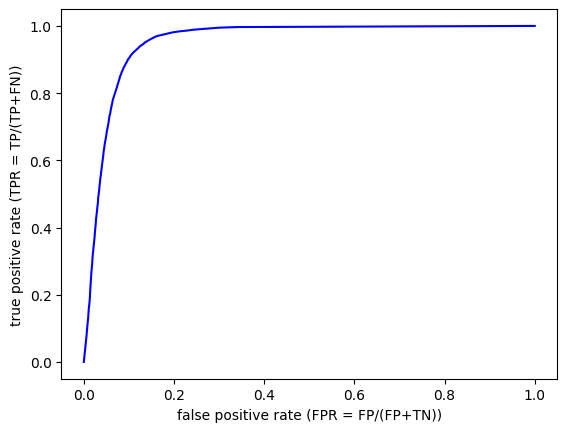

In [651]:
if train_generation == "generate_points_gaussian_gaussian" :
    auc_score = plot_ROC("gaussian_gaussian",(x_test,m,M,train_s_mu,train_s_s,train_b_mu,train_b_s),y_test,500,"-")
else :
    auc_score = plot_ROC("gaussian_exp",(x_test,m,M,train_s_mu,train_s_s,train_b_loc,train_b_lam),y_test,500,"-")

In [652]:
auc_score

0.9523128587499998

### Using scikit-learn ROC curves

Same, but using sklearn functions

In [653]:
def plot_sklearn_ROC (distribs,OBC,params,y) :
    if distribs == "gaussian_gaussian" :
        ps,pb = build_ps_pb_gaussian_gaussian(params)
    else :
        ps,pb = build_ps_pb_gaussian_exp(params)
    x = params[0]
    y_predicted_positive = predict(OBC,x)
    fpr, tpr, thresholds = roc_curve(y, ps-pb, pos_label=1)
    plt.plot(fpr,tpr)
    plt.title("ROC curve and AUC computed with sklearn")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    return auc(fpr,tpr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9531780400000001


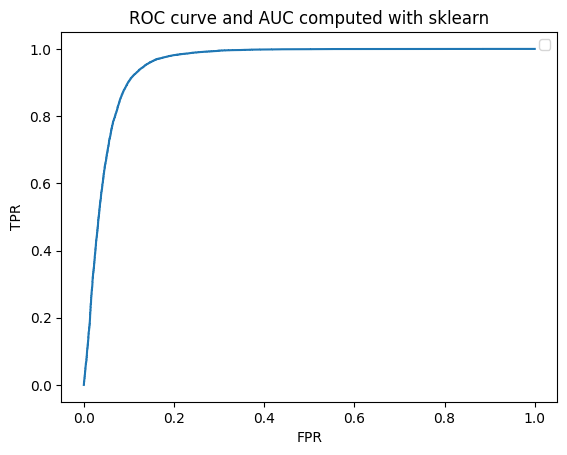

In [654]:
if train_generation == "generate_points_gaussian_gaussian" :
    sklearn_auc = plot_sklearn_ROC("gaussian_gaussian",OBC,(x_test,m,M,train_s_mu,train_s_s,train_b_mu,train_b_s),y_test)
    print(sklearn_auc)
else :
    sklearn_auc = plot_sklearn_ROC("gaussian_exp",OBC,(x_test,m,M,train_s_mu,train_s_s,train_b_loc,train_b_lam),y_test)
    print(sklearn_auc)

### Plotting ROC curve introducing increasingly big shift in signal center of distribution

Here are several ROC curves. We see the classifier becomes less accurate as translation shift converge
to background center of mass

Text(0.5, 1.0, 'The bigger delta is the more red is the ROC curve')

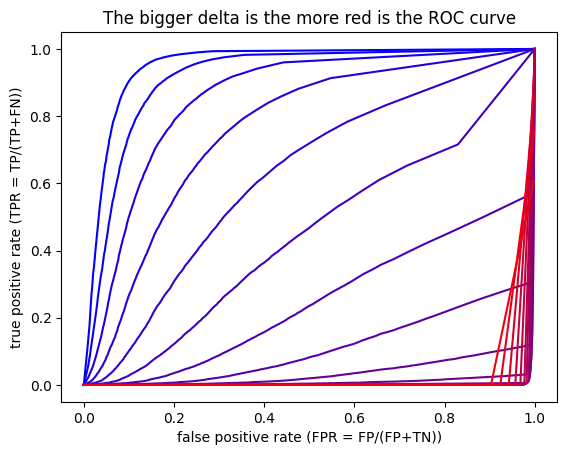

In [655]:
bins = 20
k = 0
for delta in np.linspace(0,5,bins) :
    color = (k*1/bins,0,1-k*1/bins)
    if train_generation == "generate_points_gaussian_gaussian" :
        auc_score = plot_ROC("gaussian_gaussian",(x_test,m,M,train_s_mu-delta,train_s_s,train_b_mu,train_b_s),y_test,200,"-",color)
    else :
        auc_score = plot_ROC("gaussian_exp",(x_test,m,M,train_s_mu-delta,train_s_s,train_b_loc,train_b_lam),y_test,200,"-",color)
    k += 1
plt.title("The bigger delta is the more red is the ROC curve")

### Compare ROC curves with score ps-pb and ps/pb

In [656]:
def compare_ROC_for_two_scores (distribs,params,y,bins) :
    fig = plt.figure(constrained_layout=True, figsize=(8, 4))
    axs = fig.subplots(1, 2, sharex=True)
    minus_auc = plot_ROC(distribs,params,y,bins,"-","b",axs[0])
    div_auc = plot_ROC(distribs,params,y,bins,"/","r",axs[1])

    axs[0].set_xlabel("false positive rate (FPR = FP/(FP+TN))")
    axs[1].set_xlabel("false positive rate (FPR = FP/(FP+TN))")
    axs[0].set_ylabel("true positive rate (TPR = TP/(TP+FN))")
    axs[1].set_ylabel("true positive rate (TPR = TP/(TP+FN))")
    fig.suptitle("ROC curves with score ps-pb (left plot) and score ps/pb (right plot))")
    plt.legend()
    return minus_auc, div_auc

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


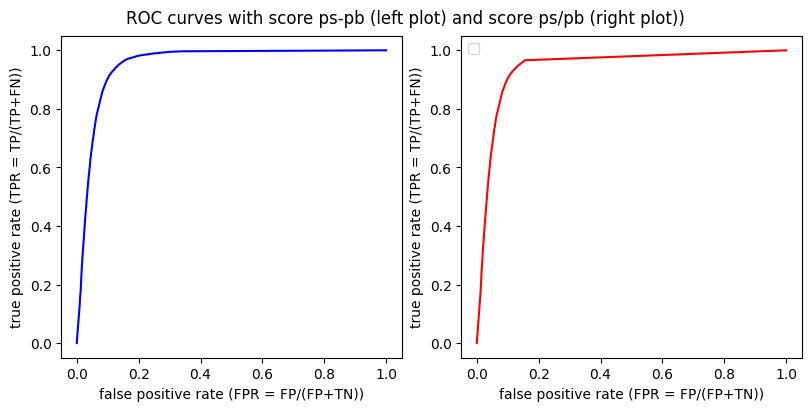

In [657]:
if train_generation == "generate_points_gaussian_gaussian" :
    compare_ROC_for_two_scores("gaussian_gaussian",(x_test,m,M,train_s_mu,train_s_s,train_b_mu,train_b_s),y_test,500)
else :
    compare_ROC_for_two_scores("gaussian_exp",(x_test,m,M,train_s_mu,train_s_s,train_b_loc,train_b_lam),y_test,500)

### Plot of ps/pb as a function of ps-pb

In the cell below we see that ps/pb is an inscreasingly monotonous function of ps-pb. it explains why ROC curves are the same

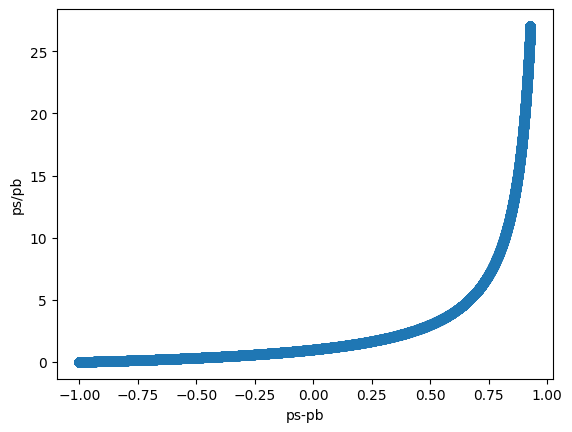

In [658]:
ps,pb = build_ps_pb_gaussian_gaussian((x_test,m,M,train_s_mu,train_s_s,train_b_mu,train_b_s))
plt.scatter(np.sort(ps-pb),np.sort(ps/pb))
plt.xlabel("ps-pb")
plt.ylabel("ps/pb")
plt.show()

### Comparing score distribution with ps-pb and ps/pb as score

Even though ROC curves are the same, the graph above show that high values of ps-pb corresponds to highly spread ps/pb values. Thus scores distribution should be substantaly different.

In [659]:
def normalize_score (score,lowest_score,highest_score) :
    return ((score-lowest_score)/(highest_score-lowest_score))

In [660]:
def score_distribution (distribs,params,y,bins,score_function,axis) :
    if distribs == "gaussian_gaussian" :
        ps,pb = build_ps_pb_gaussian_gaussian(params)
    else :
        ps,pb = build_ps_pb_gaussian_exp(params)
    if score_function == "-" :
        score = ps-pb
    else :
        score = ps/pb
    lowest_score, highest_score = np.min(score), np.max(score)
    mask_positive = (y==1)
    normalized_score = normalize_score(score,lowest_score,highest_score)
    axis.hist(normalized_score[mask_positive],bins, color="red", alpha=1, label="Signal")
    axis.hist(normalized_score[np.logical_not(mask_positive)],bins,color="blue", alpha=0.5, label="Background")
    if score_function=="-" :
        axis.set_title("Score distribution with ps-pb as score")
        axis.set_xlabel("Score (ps-pb)")
        axis.set_ylabel("Number of events")
    else :
        axis.set_title("Score distribution with ps/pb as score")
        axis.set_xlabel("Score (ps/pb)")
        axis.set_ylabel("Number of events")

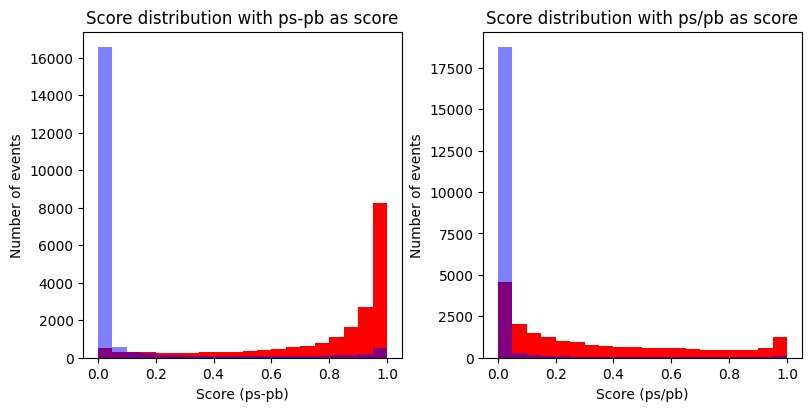

In [661]:
fig = plt.figure(constrained_layout=True, figsize=(8, 4))
axs = fig.subplots(1, 2, sharex=True)
if train_generation == "generate_points_gaussian_gaussian" :
    score_distribution("gaussian_gaussian",(x_test,m,M,train_s_mu,train_s_s,train_b_mu,train_b_s),y_test,20,"-",axs[0])
    score_distribution("gaussian_gaussian",(x_test,m,M,train_s_mu,train_s_s,train_b_mu,train_b_s),y_test,20,"/",axs[1])
else :
    score_distribution("gaussian_exp",(x_test,m,M,train_s_mu,train_s_s,train_b_loc,train_b_lam),y_test,20,"-",axs[0])
    score_distribution("gaussian_exp",(x_test,m,M,train_s_mu,train_s_s,train_b_loc,train_b_lam),y_test,20,"/",axs[1])

## 2D

PDF of 2D exponential and guassian distribution :
\begin{align*}
    z &\mapsto \lambda_x \lambda_y \exp(-\lambda_x x - \lambda_y y)\\
    z &\mapsto \frac{1}{2\pi} \left(\frac{\sigma_x \sigma_y}{2}\right)^{-\frac{1}{2}} \exp\left(-\frac{1}{2} \left(\frac{(x-\mu_x)^2}{\sigma_x} + \frac{(y-\mu_y)^2}{\sigma_y}\right)\right)
\end{align*}

# 2D problem

Here the task is the same as before but with two dimension. We provide $\mathbb{R}^2$ with an orthonormal basis (x1,x2). Then we randomly generate points labeled "0" for background or "1" for signal that we use to train a model that will aim at classifying such points. We introduce nuisance in two ways :
- Translation along the first axis x1. That is we randomly generate signal and background points but the first coordinate of each point is shifted by the same amount. The nuisance parameter in this process is how much each point is translated.
- Rotation. That is we generate signal points with a Gaussian distribution, where the center of the distribution is a point on a fictive circle centered at the origin. To this set of points, we associate a background set of points that are generated with a Gaussian distribution centered at the point diametrically opposed to the center of the distribution for the signal points. The nuisance parameter in this process is the angle between the x1-axis and the line connecting the center of the distribution for the signal points and the center of the associated background points

## Functions

### Functions used for points generation

In [662]:
def generate_cluster(loc, parameter, num_points, dist_type):
    if dist_type == "gaussian":
        # Generate samples from a multivariate normal distribution
        samples = np.random.multivariate_normal(loc, parameter, num_points)
    elif dist_type == "exponential":
        # Generate samples from a 2D exponential distribution
        samples = np.random.exponential(parameter, size=(num_points, 2)) + loc
    else:
        raise ValueError("Invalid distribution type. Supported types are 'gaussian' and 'exponential'.")
    return samples

In [663]:
def exp_pdf_2D (p,d) :
    # Tool function used in calculate_optimal_bayes_classifier
    if len(np.shape(p)) == 1 :
        return np.prod(np.exp(-np.array(p)/d))
    else :
        return np.prod(np.exp(-np.array(p)/d),axis=1)

In [664]:
def build_nuisance_centers (nuisance_params, distance_s_b) :
    nuisance_kind,nb_nuisance_values,nuisance_bounds,nuisance_values = nuisance_params
    # Calulate nuisance values if they are not explicitly given in nuisance_values
    if nuisance_values == "linspace" :
        nuisance_values = np.linspace(nuisance_bounds[0],nuisance_bounds[1],nb_nuisance_values)
    elif nuisance_values == "random" :
        nuisance_values = np.random.uniform(nuisance_bounds[0],nuisance_bounds[1],nb_nuisance_values)
    # Calculate cluster centers according to the kind of nuisance introduced
    if nuisance_kind == "x1_translation" :
        nuisance_centers = [[(x,0),(x+distance_s_b,0)] for x in nuisance_values]
    elif nuisance_kind == "rotation" :
        nuisance_centers = [[(-distance_s_b*np.cos(z),-distance_s_b*np.sin(z)),(distance_s_b*np.cos(z),distance_s_b*np.sin(z))] for z in nuisance_values]
    else :
        raise ValueError("Invalid nuisance kind")
    return nuisance_centers

In [665]:
def generate_points (distributions_params, nuisance_centers) :
    try :
        b_dist,b_param,b_nb_events,s_dist,s_param,s_nb_events = distributions_params
    except :
        raise ValueError("Invalid number of parameters")
    
    DB = generate_cluster(nuisance_centers[0][0], b_param, b_nb_events, b_dist)
    DS = generate_cluster(nuisance_centers[0][1], s_param, s_nb_events, s_dist)
    for i in range(1,len(nuisance_centers)) :
        DB = np.vstack((DB,generate_cluster(nuisance_centers[i][0], b_param, b_nb_events, b_dist)))
        DS = np.vstack((DS,generate_cluster(nuisance_centers[i][1], s_param, s_nb_events, s_dist)))
    return DB,DS

### Functions used for OBC

In [666]:
def calculate_optimal_bayes_classifier(points, dist_types):
    # Calculate the number of points and the number of classes
    num_classes = len(points)
    num_points = sum(len(points[i]) for i in range(num_classes))

    # Calculate the class priors
    class_priors = [len(points[i])/num_points for i in range(num_classes)]

    # Calculate the means and covariances for each class
    means, covs = [], []
    for i in range(num_classes):
        class_points = points[i].tolist()
        mean = np.mean(class_points, axis=0)
        cov = np.cov(class_points, rowvar=False)
        means.append(mean)
        covs.append(cov)
    
    def predict(point):
        # Calculate the likelihoods for each class
        if dist_types[0] == "gaussian":
            likelihoods = [multivariate_normal.pdf(point, mean=means[0], cov=covs[0])]
            if dist_types[1] == "gaussian":
                likelihoods.append(multivariate_normal.pdf(point, mean=means[1], cov=covs[1]))
            elif dist_types[1] == "exponential":
                likelihoods.append(np.prod(np.exp(-np.array(point)/means[1]),axis=1))
            else:
                raise ValueError("Invalid distribution type. Supported types are 'gaussian' and 'exponential'.")
        elif dist_types[0] == "exponential":
            likelihoods = [exp_pdf_2D(point,means[0])]
            if dist_types[1] == "gaussian":
                likelihoods.append(multivariate_normal.pdf(point, mean=means[1], cov=covs[1]))
            elif dist_types[1] == "exponential":
                likelihoods.append(np.prod(np.exp(-np.array(point)/means[1]),axis=1))
            else:
                raise ValueError("Invalid distribution type. Supported types are 'gaussian' and 'exponential'.")

        # Calculate the posterior probabilities for each class
        posteriors = [likelihoods[i] * class_priors[i] for i in range(num_classes)]

        # Return the class with the highest posterior probability
        return np.argmax(posteriors,axis=0), posteriors

    return predict

In [667]:
def plot_classifier(points, classifier, dist_types):
    # Extract the x and y coordinates of the points
    x, y = np.hstack((points[0][:, 0],points[1][:, 0])), np.hstack((points[0][:, 1],points[1][:, 1]))
    
    # Predict label of the points
    labels = np.hstack((classifier(points[0])[0],classifier(points[1])[0]))
    # Create the plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=labels, cmap="coolwarm")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    #ax.set_title(f"2D OBC for {dist_types[0].capitalize()} and {dist_types[1].capitalize()} distributions")

    # Create a grid of points over the plot
    x_min, x_max, y_min, y_max = ax.axis()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    print(type(grid_points[0]))

    # Classify the points on the grid
    grid_labels = np.array([classifier(point)[0] for point in grid_points])

    # Color the grid points according to their class
    ax.scatter(grid_points[:, 0], grid_points[:, 1], c=grid_labels, cmap="coolwarm", alpha=0.1, marker=",")

### Functions used for GBC

In [668]:
def build_x_y_for_sklearn_model (DB,DS,shuffle=True) :
    labels = np.vstack((np.zeros((np.shape(DB)[0],1)),np.ones((np.shape(DS)[0],1))))
    D_labeled = np.hstack((np.vstack((DB,DS)),labels))
    if shuffle :
        np.random.shuffle(D_labeled)
    x, y = D_labeled[:,0:2], D_labeled[:,2]
    return x, y

### Functions used to remove bias

In this section we build functions to remove the bias. We assume we don't know the class of the points.

#### For translation and/or dilatation bias

We translate the points so their barycenter is at the origin and then we scale them so the standard deviation equals 1

In [669]:
def normalize_points (points):
    # Translate the points to the origin
    translated_points = points - np.mean(points, axis=0)
    
    # Scale the points so that the standard deviation of each feature is 1
    std_dev_x = np.std(translated_points[:, 0])
    std_dev_y = np.std(translated_points[:, 1])
    normalized_points = translated_points / np.array([std_dev_x, std_dev_y])
    
    return normalized_points

#### For rotation bias

We calculate the average absolute coordinates which have to be approximately equal to the coordinates of the center of signal distribution. Then we retrieve the nuisance parameter which is the angle between the x1-axis and the line passing through the origin and the averaged point. Finaly we apply a negative rotation of this angle to all the points. 

In [670]:
def rotate_to_zero_nuisance (points):
    # Calculate the absolute coordinates
    abs_coords = np.abs(points)
    # Calculate the average of the absolute coordinates
    avg_abs_coords = np.mean(abs_coords, axis=0)
    # Calculate the approximate nuisance parameter
    angle = np.arctan2(avg_abs_coords[1],avg_abs_coords[0])
    # Rotate the points around the origin by the angle
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    rotated_points = points @ rot_matrix
    return rotated_points

In [671]:
def debias (DB, DS, b_nb_events, s_nb_events, nb_nuisance_values, nuisance_kind) :
    if nuisance_kind == "rotation" :
        all_debiased_points = []
        for i in range(nb_nuisance_values) :
            points = np.vstack((DB[i*b_nb_events:(i+1)*b_nb_events],DS[i*s_nb_events:(i+1)*s_nb_events]))
            debiased_points = rotate_to_zero_nuisance(points)
            all_debiased_points.append(debiased_points)
        debiased_DB = np.vstack([all_debiased_points[i][0:b_nb_events] for i in range(nb_nuisance_values)])
        debiased_DS = np.vstack([all_debiased_points[i][b_nb_events:b_nb_events+s_nb_events] for i in range(nb_nuisance_values)])
    elif nuisance_kind == "x1_translation" :
        all_debiased_points = []
        for i in range(nb_nuisance_values) :
            points = np.vstack((DB[i*b_nb_events:(i+1)*b_nb_events],DS[i*s_nb_events:(i+1)*s_nb_events]))
            debiased_points = normalize_points(points)
            all_debiased_points.append(debiased_points)
        debiased_DB = np.vstack([all_debiased_points[i][0:b_nb_events] for i in range(nb_nuisance_values)])
        debiased_DS = np.vstack([all_debiased_points[i][b_nb_events:b_nb_events+s_nb_events] for i in range(nb_nuisance_values)])
    else :
        raise ValueError("Invalid nuisance kind")
    return debiased_DB, debiased_DS

#### Functions to show the generated points

In [672]:
def scatter_points (nuisance_kind, training_points, D_test, b_nb_events, s_nb_events, nb_nuisance_values, remove_bias=False) :
    DB, DS = training_points[0], training_points[1]
    
    fig = plt.figure(constrained_layout=True, figsize=(10, 5))
    axs = fig.subplots(1, 2, sharex=True)
    
    alpha_raw = 0.2
    if not remove_bias :
        alpha_raw = 1
    
    axs[0].scatter(DB[:,0],DB[:,1],s=10,c="b",marker="+",alpha=alpha_raw)
    axs[0].scatter(DS[:,0],DS[:,1],s=10,c="r",marker="+",alpha=alpha_raw)
    axs[1].scatter(D_test[:,0],D_test[:,1],s=10,c="g",marker="+",alpha=alpha_raw)
    
    if remove_bias :
        if nuisance_kind == "rotation" :
            derotated_DB, derotated_DS = rotate_to_zero_nuisance(DB), rotate_to_zero_nuisance(DS)
            derotated_D_test = rotate_to_zero_nuisance(D_test)
            axs[0].scatter(derotated_DB[:,0],derotated_DB[:,1],s=10,c="b",marker=".")
            axs[0].scatter(derotated_DS[:,0],derotated_DS[:,1],s=10,c="r",marker=".")
            axs[1].scatter(derotated_D_test[:,0],derotated_D_test[:,1],s=10,c="g",marker=".")
        elif nuisance_kind == "x1_translation" :
            normalized_DB, normalized_DS = debias (DB, DS, b_nb_events, s_nb_events, nb_nuisance_values, nuisance_kind)
            normalized_D_test = normalize_points(D_test)
            axs[0].scatter(normalized_DB[:,0],normalized_DB[:,1],s=10,c="b",marker=".")
            axs[0].scatter(normalized_DS[:,0],normalized_DS[:,1],s=10,c="r",marker=".")
            axs[1].scatter(normalized_D_test[:,0],normalized_D_test[:,1],s=10,c="g",marker=".")
        else : 
            raise ValueError("Invalid nuisance kind")
        axs[0].legend(["raw background","raw signal","debiased background", "debiased signal"])
        axs[1].legend(["raw","debiased"])
    else :
        axs[0].legend(["background","signal"])
        
    axs[0].set_title("Train points")
    axs[1].set_title("Test points")
    axs[0].set_xlabel("x1")
    axs[0].set_ylabel("x2")
    axs[1].set_xlabel("x1")
    axs[1].set_ylabel("x2")
    
    plt.show()

## Parameters

2D parameters description

- dist : the distribution used to generate the points, either gaussian or exponential
- param : covariance matrix if distribution if gaussian. Scale if distribution is exponential
- nb_events : number of events generated for each value of the nuisance parameter

- available nuisance kinds : "x1_translation","rotation"
- nuisance_kind : the way nuisance is introduced
- nb_nuisance_values : the number of values the nuisance parameter takes
- nuisance_bounds : the smallest and biggest possible values for the nuisance parameter
- nuisance_values : either
    - a list with the chosen nuisance values
    - "random" for the values to be randomly chosen between nuisance bounds
    - "linspace" for the values to be regularly chosen between nuisance bounds
- distance_s_b : the distance between signal cluster and background cluster for a specific nuisance value
                    

In [673]:
Params_2D = {"b_dist" : "gaussian",
             "b_param" : [[1,0],[0,1]],
             "b_nb_train_events" : 1000,
             "b_nb_test_events" : 200,
             "s_dist" : "gaussian",
             "s_param" : [[1,0],[0,1]],
             "s_nb_train_events" : 1000,
             "s_nb_test_events" : 200,
             "nuisance_kind" : "rotation",
             "nb_train_nuisance_values" : 5,
             "nb_test_nuisance_values" : 5,
             "nuisance_bounds" : [0,np.pi/2],
             "nuisance_values" : "linspace",
             "distance_s_b" : 1}


b_dist = Params_2D["b_dist"]
b_param = Params_2D["b_param"]
b_nb_train_events = Params_2D["b_nb_train_events"]
b_nb_test_events = Params_2D["b_nb_test_events"]
s_dist = Params_2D["s_dist"]
s_param = Params_2D["s_param"]
s_nb_train_events = Params_2D["s_nb_train_events"]
s_nb_test_events = Params_2D["s_nb_test_events"]

nuisance_kind = Params_2D["nuisance_kind"]
nb_train_nuisance_values = Params_2D["nb_train_nuisance_values"]
nb_test_nuisance_values = Params_2D["nb_test_nuisance_values"]
nuisance_bounds = Params_2D["nuisance_bounds"]
nuisance_values = Params_2D["nuisance_values"]

distance_s_b = Params_2D["distance_s_b"]


distributions_train_params = b_dist,b_param,b_nb_train_events,s_dist,s_param,s_nb_train_events
distributions_test_params = b_dist,b_param,b_nb_test_events,s_dist,s_param,s_nb_test_events
nuisance_params = nuisance_kind,nb_train_nuisance_values,nb_test_nuisance_values,nuisance_bounds,nuisance_values

## Baselines

### Generation or test points

We will test all the baselines with these points

In [674]:
center = build_nuisance_centers((nuisance_kind,nb_test_nuisance_values,nuisance_bounds,"random"),distance_s_b)
DB_test,DS_test = generate_points((b_dist,b_param,b_nb_test_events,s_dist,s_param,s_nb_test_events),center)
x_test, y_test = build_x_y_for_sklearn_model(DB_test,DS_test,shuffle=False)

### Raw classification

In this baseline we generate the train events with 1 value nuisance parameter : the average one. Then we train and evaluate the classifiers with test points generated with one random value of the nuisance parameter.

#### Generation of train points

##### Train points

In [675]:
raw_nuisance_centers = build_nuisance_centers((nuisance_kind,1,nuisance_bounds,[0.5*(nuisance_bounds[0]+nuisance_bounds[1])]),distance_s_b)
raw_DB_train,raw_DS_train = generate_points((b_dist,b_param,nb_train_nuisance_values*b_nb_train_events,s_dist,s_param,nb_train_nuisance_values*s_nb_train_events),raw_nuisance_centers)
raw_training_points = [raw_DB_train,raw_DS_train]
raw_x_train, raw_y_train = build_x_y_for_sklearn_model(raw_DB_train,raw_DS_train)

#### Show points

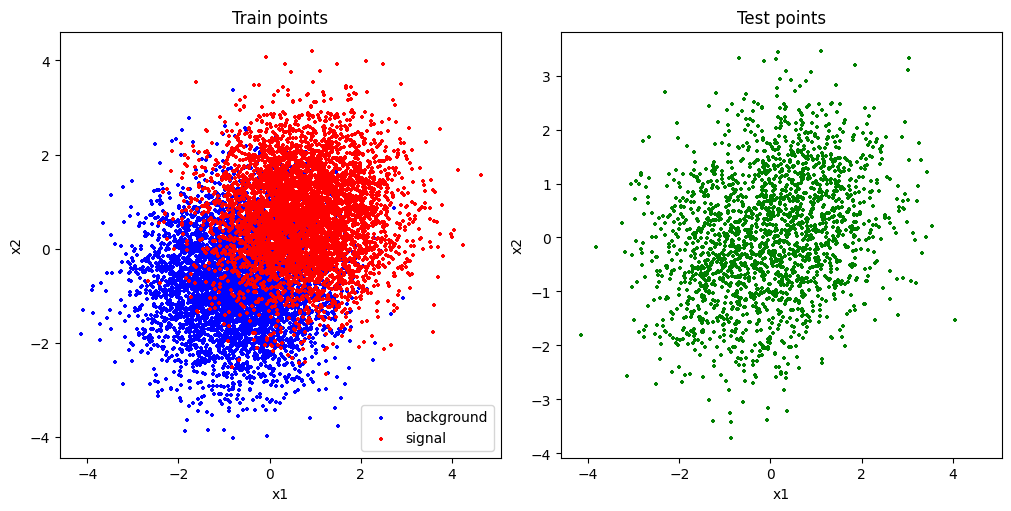

In [676]:
scatter_points(nuisance_kind,raw_training_points,x_test,b_nb_train_events,s_nb_train_events,nb_train_nuisance_values,remove_bias=False)

#### Build and train the models

##### OBC

In the cell below, we train the OBC on the train set and we show the regions while scattering the train set.

<class 'numpy.ndarray'>


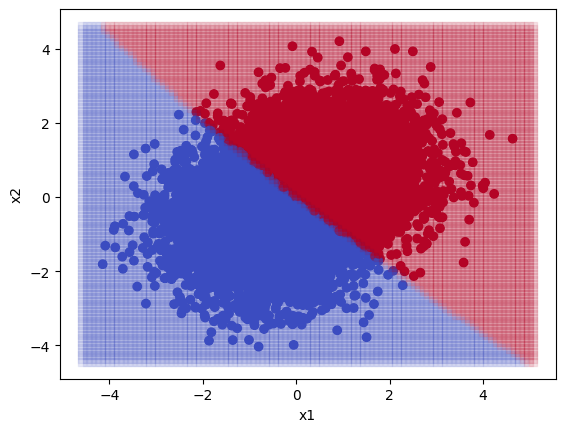

In [677]:
raw_OBC = calculate_optimal_bayes_classifier(raw_training_points,[b_dist,s_dist])
plot_classifier(raw_training_points, raw_OBC, [b_dist,s_dist])

##### BDT

In [678]:
raw_GBC = GBC()
raw_GBC.fit(raw_x_train,raw_y_train)

GradientBoostingClassifier()

#### Evaluate the models

##### OBC

0.8241390000000001

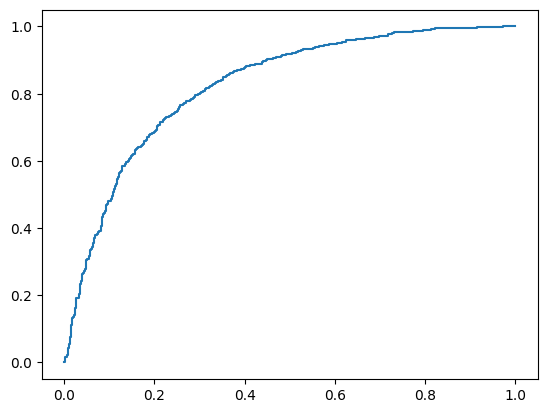

In [679]:
raw_OBC_fpr,raw_OBC_tpr,thresholds = roc_curve(y_test,raw_OBC(x_test)[1][1], pos_label=1)
raw_OBC_auc_score = auc(raw_OBC_fpr,raw_OBC_tpr)
plt.plot(raw_OBC_fpr,raw_OBC_tpr)
raw_OBC_auc_score

##### BDT

0.9082985

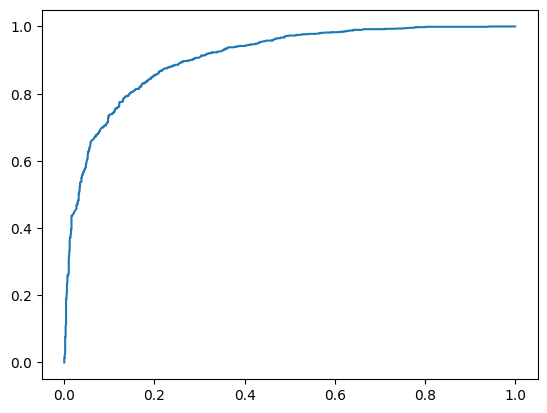

In [680]:
raw_GBC_fpr,raw_GBC_tpr,thresholds = roc_curve(y_test,raw_GBC.predict_proba(x_test)[:,1], pos_label=1)
raw_GBC_auc_score = auc(raw_GBC_fpr,raw_GBC_tpr)
plt.plot(raw_GBC_fpr,raw_GBC_tpr)
raw_GBC_auc_score

### Noised classification

In this baseline, we generate the events with 10 values of nuisance parameter. They are regurarly chosen between the nuisance bounds.

#### Generation of train points

##### Train points

In [681]:
noised_nuisance_centers = build_nuisance_centers((nuisance_kind,nb_train_nuisance_values,nuisance_bounds,"linspace"),distance_s_b)
noised_DB_train,noised_DS_train = generate_points((b_dist,b_param,b_nb_train_events,s_dist,s_param,s_nb_train_events),noised_nuisance_centers)
noised_training_points = [noised_DB_train,noised_DS_train]
noised_x_train, noised_y_train = build_x_y_for_sklearn_model(noised_DB_train,noised_DS_train)

#### Show points

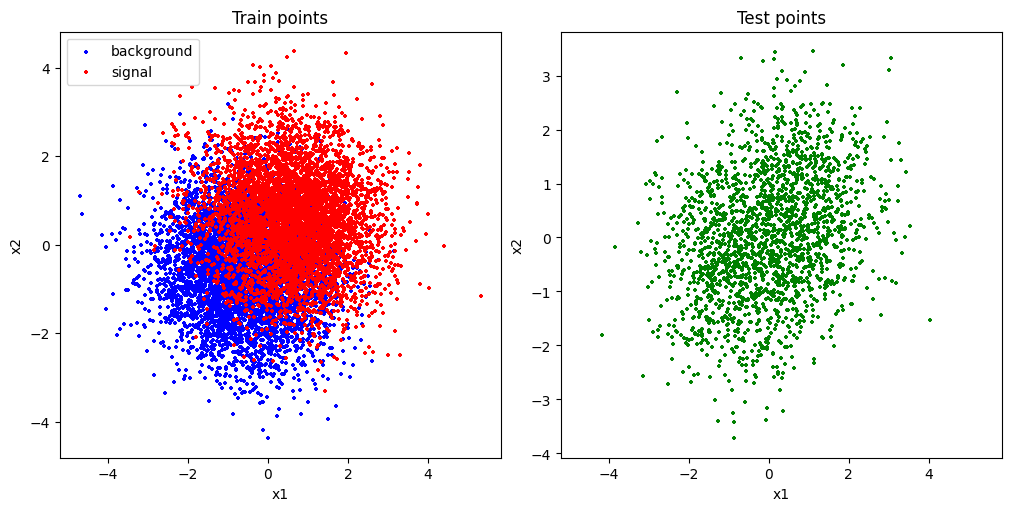

In [682]:
scatter_points(nuisance_kind,noised_training_points,x_test,b_nb_train_events,s_nb_train_events,nb_train_nuisance_values,remove_bias=False)

#### Build and train the models

##### OBC

In the cell below, we train the OBC on the train set and we show the regions while scattering the train set.

<class 'numpy.ndarray'>


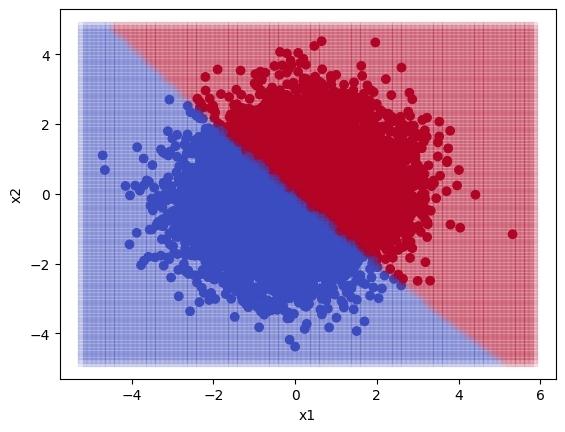

In [683]:
noised_OBC = calculate_optimal_bayes_classifier(noised_training_points,[b_dist,s_dist])
plot_classifier(noised_training_points, noised_OBC, [b_dist,s_dist])

##### BDT

In [684]:
noised_GBC = GBC()
noised_GBC.fit(noised_x_train,noised_y_train)

GradientBoostingClassifier()

#### Evaluate the models

##### OBC

0.8026629999999999

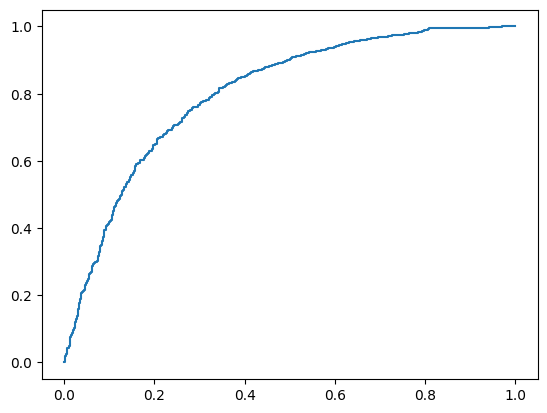

In [685]:
noised_OBC_fpr,noised_OBC_tpr,thresholds = roc_curve(y_test,noised_OBC(x_test)[1][1], pos_label=1)
noised_OBC_auc_score = auc(noised_OBC_fpr,noised_OBC_tpr)
plt.plot(noised_OBC_fpr,noised_OBC_tpr)
noised_OBC_auc_score

##### BDT

0.9104845

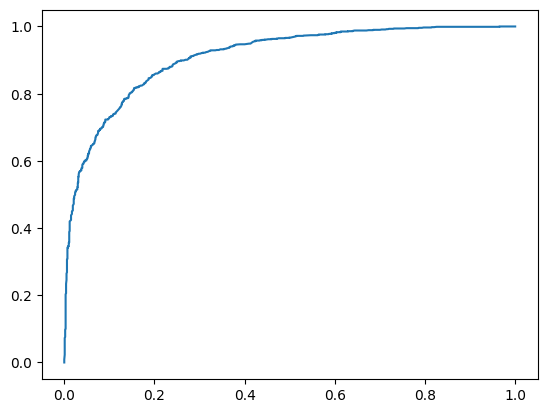

In [686]:
noised_GBC_fpr,noised_GBC_tpr,thresholds = roc_curve(y_test,noised_GBC.predict_proba(x_test)[:,1], pos_label=1)
noised_GBC_auc_score = auc(noised_GBC_fpr,noised_GBC_tpr)
plt.plot(noised_GBC_fpr,noised_GBC_tpr)
noised_GBC_auc_score

### Denoised classification

In this baseline, we generate the events in the same way we did for for noised classification, but we apply a function that aims at removing the bias introduced by nuisance parameter

#### Generation of train points

##### Train points

In [687]:
to_debias_nuisance_centers = build_nuisance_centers((nuisance_kind,nb_train_nuisance_values,nuisance_bounds,"linspace"),distance_s_b)
to_debias_DB_train,to_debias_DS_train = generate_points((b_dist,b_param,b_nb_train_events,s_dist,s_param,s_nb_train_events),to_debias_nuisance_centers)
to_debias_training_points = [to_debias_DB_train,to_debias_DS_train]
debiased_DB_train, debiased_DS_train = debias(to_debias_DB_train, to_debias_DS_train, b_nb_train_events, s_nb_train_events, nb_train_nuisance_values, nuisance_kind)
debiased_training_points = [debiased_DB_train, debiased_DS_train]
debiased_x_train, debiased_y_train = build_x_y_for_sklearn_model(debiased_DB_train,debiased_DS_train)

#### Remove bias from test points

In [688]:
debiased_DB_test, debiased_DS_test = debias(DB_test, DS_test, b_nb_test_events, s_nb_test_events, nb_test_nuisance_values, nuisance_kind)
debiased_x_test = np.vstack((debiased_DB_test, debiased_DS_test))

#### Show points

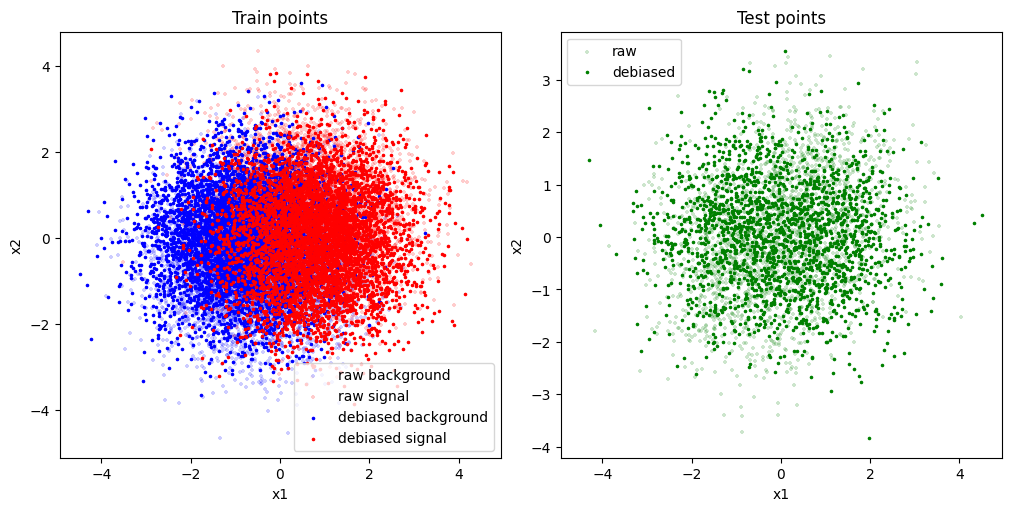

In [689]:
scatter_points(nuisance_kind,to_debias_training_points,x_test,b_nb_train_events,s_nb_train_events,nb_train_nuisance_values,remove_bias=True)

#### Build and train the models

##### OBC

In the cell below, we train the OBC on the train set and we show the regions while scattering the train set.

In [690]:
debiased_OBC = calculate_optimal_bayes_classifier(debiased_training_points,[b_dist,s_dist])
#plot_classifier(debiased_training_points, debiased_OBC, [b_dist,s_dist])

##### BDT

In [691]:
debiased_GBC = GBC()
debiased_GBC.fit(debiased_x_train,debiased_y_train)

GradientBoostingClassifier()

#### Evaluate the models

##### OBC

0.818854

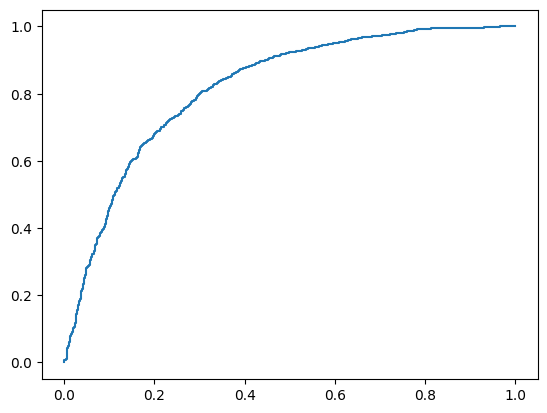

In [692]:
debiased_OBC_fpr,debiased_OBC_tpr,thresholds = roc_curve(y_test,debiased_OBC(debiased_x_test)[1][1], pos_label=1)
debiased_OBC_auc_score = auc(debiased_OBC_fpr,debiased_OBC_tpr)
plt.plot(debiased_OBC_fpr,debiased_OBC_tpr)
debiased_OBC_auc_score

##### BDT

0.9172564999999999

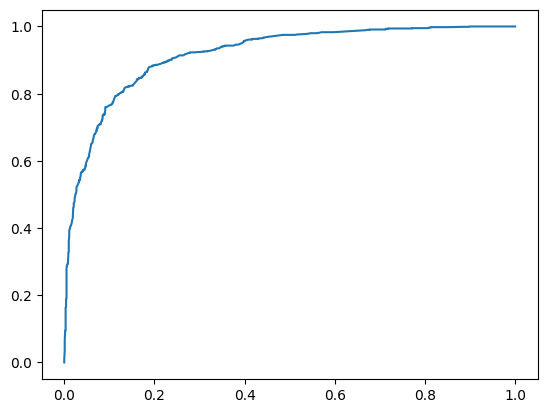

In [693]:
debiased_GBC_fpr,debiased_GBC_tpr,thresholds = roc_curve(y_test,debiased_GBC.predict_proba(debiased_x_test)[:,1], pos_label=1)
debiased_GBC_auc_score = auc(debiased_GBC_fpr,debiased_GBC_tpr)
plt.plot(debiased_GBC_fpr,debiased_GBC_tpr)
debiased_GBC_auc_score

### Comparing baselines

In [694]:
print("raw : ", raw_OBC_auc_score, raw_GBC_auc_score)
print("noised : ", noised_OBC_auc_score, noised_GBC_auc_score)
print("debiased : ", debiased_OBC_auc_score, debiased_GBC_auc_score)

raw :  0.8241390000000001 0.9082985
noised :  0.8026629999999999 0.9104845
debiased :  0.818854 0.9172564999999999
